In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def show_image_with_pyplot(img ,grayscale=True, ax=None):
    if grayscale:  img_plt = img
    else:          img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    if ax is None:
        fig = plt.figure(figsize=(14, 10))
        ax = plt.axes(xticks=[], yticks=[])
    else:
      ax.set_xticks([])
      ax.set_yticks([])
    
    if grayscale:  ax.imshow(img_plt, cmap='gray')
    else:               ax.imshow(img_plt)

In [0]:
# requires a grayscale image as input
def preprocessing(img):
    # create a CLAHE object for Histogram equalisation and improvng the contrast.
    img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(8,8))
    enhanced = clahe.apply(img_plt)

    # Edge preserving smoother: https://dsp.stackexchange.com/questions/60916/what-is-the-bilateral-filter-category-lpf-hpf-bpf-or-bsf
    blurred = cv2.GaussianBlur(enhanced, (15,15), 0)
    blurred = cv2.bilateralFilter(blurred,7,75,75)

    # opening for clearing some noise
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, se)

    thresholded_img = cv2.adaptiveThreshold(opened, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
    inverted = cv2.bitwise_not(thresholded_img)
    return inverted

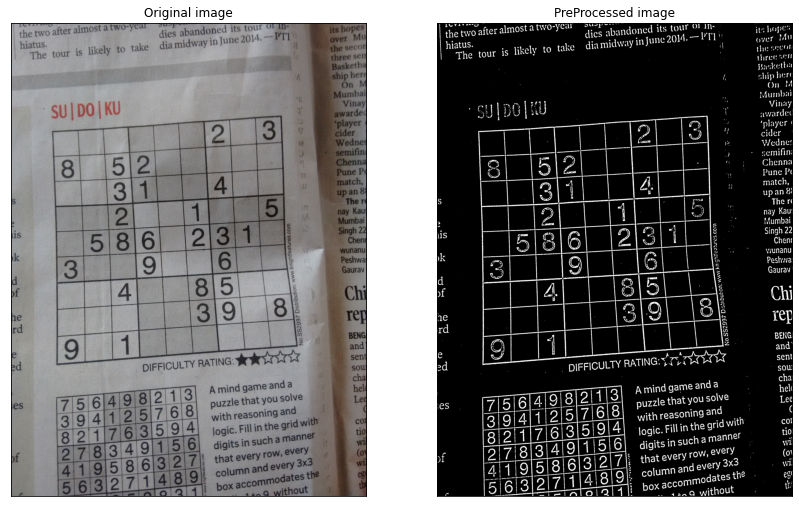

In [158]:
inp_img = cv2.imread("image2.jpg")
fig = plt.figure(figsize=(14, 14))

ax1 = plt.subplot(121)
ax1.set_title("Original image")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_title("PreProcessed image")
ax2.set_xticks([])
ax2.set_yticks([])

ret_img = preprocessing(inp_img)
show_image_with_pyplot(inp_img, grayscale=False, ax=ax1)
show_image_with_pyplot(ret_img, grayscale=True, ax=ax2)

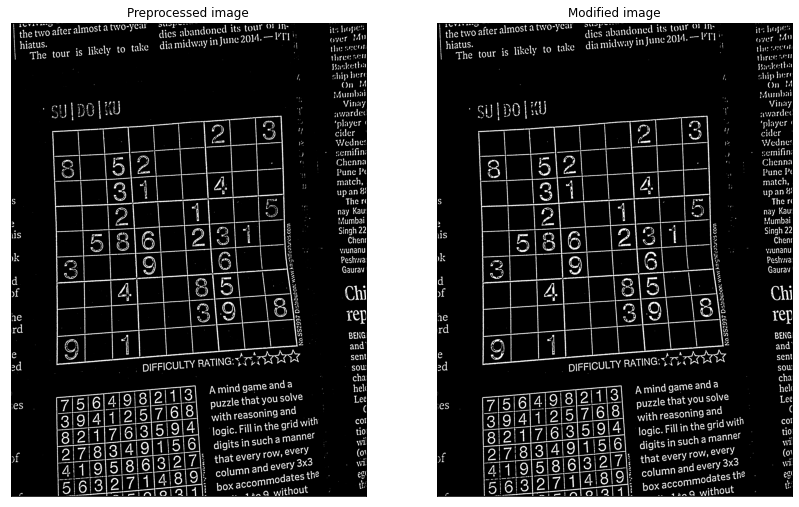

In [159]:
from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi

def fill_gaps(img, iterations=2):
  # Reference: https://stackoverflow.com/questions/28078530/gap-filling-contours-lines
  for i in range(iterations):
    out = ndi.distance_transform_edt(~img)
    out = out < 0.005 * out.max()
    out = morphology.skeletonize(out)
    out = morphology.binary_closing(out, morphology.selem.disk(4))
    out = segmentation.clear_border(out)
    out = np.array(out*255, dtype=np.uint8)
    out = cv2.bitwise_or(np.uint8(out), img)
    img = out
  return out

refined_img = fill_gaps(ret_img, iterations=4)

fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot(121)
ax1.set_title("Preprocessed image")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_title("Modified image")
ax2.set_xticks([])
ax2.set_yticks([])
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
refined_img = cv2.morphologyEx(refined_img, cv2.MORPH_OPEN, se)
show_image_with_pyplot(ret_img, grayscale=True, ax=ax1)
show_image_with_pyplot(refined_img, grayscale=True, ax=ax2)

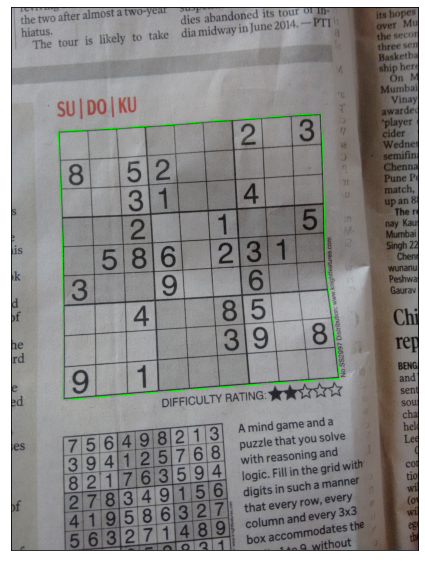

In [160]:
# find contours in the edged image, keep only the largest
contours, hierarchy = cv2.findContours(ret_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
grid_cnt = np.array(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
draw_cnt = inp_img.copy()
main_contour = grid_cnt[0]
cv2.drawContours(draw_cnt, [main_contour], -1, (0, 255, 0), 3)

show_image_with_pyplot(draw_cnt, grayscale=False)

(17, 1, 2) [[1859  645]] [[1323  684]] [[1236  686]] [[805 723]]


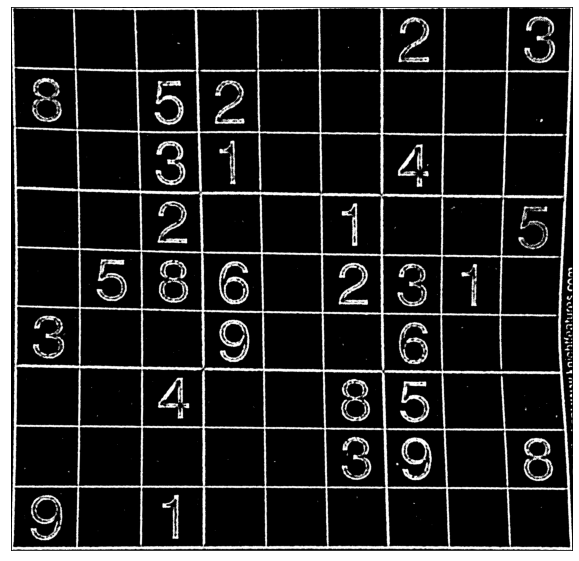

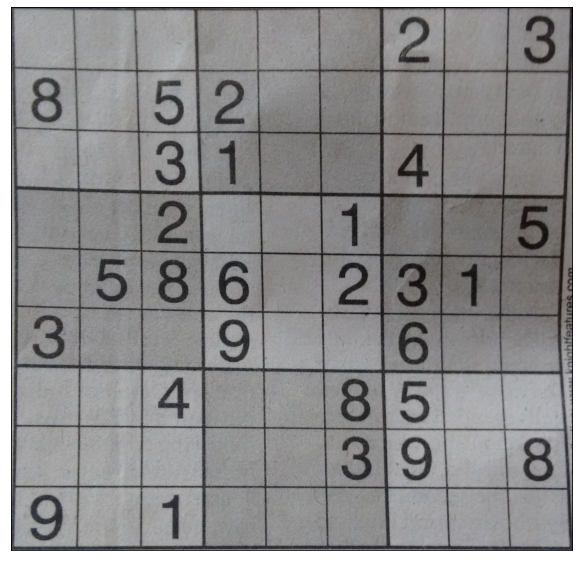

In [161]:
import operator
def perspective_transform(image, corners):
    # Reference: https://stackoverflow.com/questions/57636399/how-to-detect-sudoku-grid-board-in-opencv

    def order_corner_points(corners):
        # Bottom-right point has the largest (x + y) value
        # Top-left has point smallest (x + y) value
        # Bottom-left point has smallest (x - y) value
        # Top-right point has largest (x - y) value
        bottom_r, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        top_l, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        bottom_l, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        top_r, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        return (corners[top_l][0], corners[top_r][0], corners[bottom_r][0], corners[bottom_l][0])

    # Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners

    # Determine width of new image which is the max distance between 
    # (bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    # Determine height of new image which is the max distance between 
    # (top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    # Construct new points to obtain top-down view of image in 
    # top_r, top_l, bottom_l, bottom_r order
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], 
                    [0, height - 1]], dtype = "float32")

    # Convert to Numpy format
    ordered_corners = np.array(ordered_corners, dtype="float32")

    # Find perspective transform matrix
    matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    # Return the transformed image
    return cv2.warpPerspective(image, matrix, (width, height))

peri = cv2.arcLength(main_contour, True)
approx = cv2.approxPolyDP(main_contour, 0.0005 * peri, True)
transformed_processed = perspective_transform(ret_img, approx)
transformed_orig = perspective_transform(inp_img, approx)
print(approx.shape, approx[0], approx[1], approx[2], approx[3])

show_image_with_pyplot(transformed_processed, grayscale=True)
show_image_with_pyplot(transformed_orig, grayscale=False)

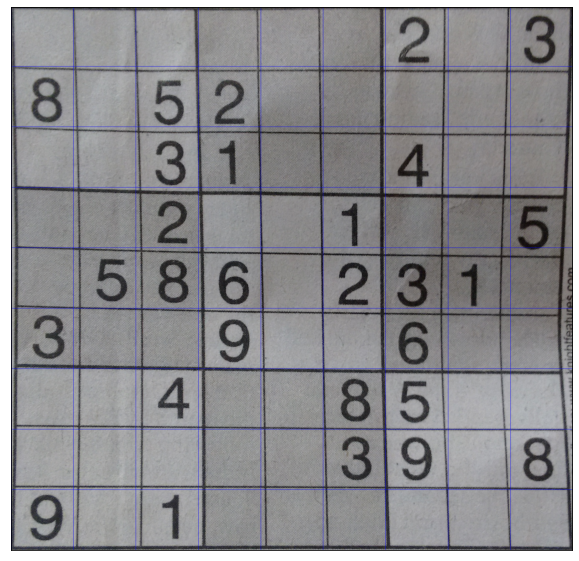

In [162]:
test = transformed_processed.copy()
test_orig = transformed_orig.copy()

lines_X = np.linspace(0, test.shape[1], num=10, dtype=int)
lines_Y = np.linspace(0, test.shape[0], num=10, dtype=int)

for line_X in lines_X:
    x1 = line_X
    y1 = 0
    x2 = x1
    y2 = test.shape[0]
    cv2.line(test_orig,(x1,y1),(x2,y2),(255,0,0),1)

for line_Y in lines_Y:
    y1 = line_Y
    x1 = 0
    y2 = y1
    x2 = test.shape[1]
    cv2.line(test_orig,(x1,y1),(x2,y2),(255,0,0),1)

show_image_with_pyplot(test_orig, grayscale=False)

In [140]:
print(lines_X)
print(lines_Y)

[  0  84 168 253 337 422 506 591 675 760]
[  0  81 162 244 325 407 488 570 651 733]


In [141]:
centers_X = [(lines_X[i] + lines_X[i-1])//2 for i in range(1, len(lines_X))]
print(centers_X)

[42, 126, 210, 295, 379, 464, 548, 633, 717]


In [142]:
centers_Y = [(lines_Y[i] + lines_Y[i-1])//2 for i in range(1, len(lines_Y))]
print(centers_Y)

[40, 121, 203, 284, 366, 447, 529, 610, 692]


In [143]:
centers = [(centers_X[i], centers_Y[j]) for i in range(len(centers_X)) for j in range(len(centers_Y))]
print(centers[:10])

[(42, 40), (42, 121), (42, 203), (42, 284), (42, 366), (42, 447), (42, 529), (42, 610), (42, 692), (126, 40)]


In [148]:
kernel_shape = (centers_X[1] - centers_X[0], centers_Y[1] - centers_Y[0])
print(kernel_shape)

(84, 81)


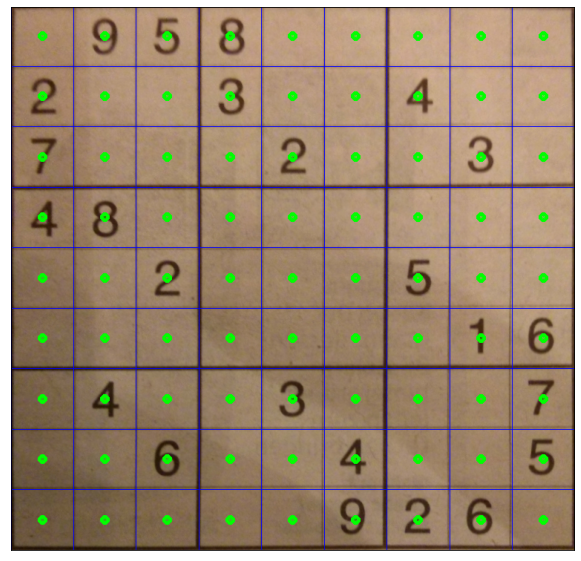

In [149]:
radius, color, thickness = kernel_shape[0]//20, (0,255,0), kernel_shape[0]//20
for center in centers:
  cv2.circle(test_orig, center, radius, color, thickness)
show_image_with_pyplot(test_orig, grayscale=False)

In [0]:
# create structuring element
def centering_se(shape: tuple, shape_ones: (int, int)):
  x = np.zeros(shape)
  assert (shape_ones[0] < shape[0]) and (shape_ones[1] < shape[1])
  width = shape_ones[0]
  height = shape_ones[1]
  
  rows, cols = shape
  for i in range(width):
    for j in range(height):
      x[i][j], x[rows-1-i][j], x[i][cols-1-j], x[rows-1-i][cols-1-j] = 1, 1, 1, 1

  return x

In [151]:
print(centering_se(kernel_shape, (2,15)))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [0]:
def recentre(img: np.ndarray, prev_center: tuple, h_se: np.ndarray, v_se: np.ndarray, h_mov_range: (int, int), v_mov_range: (int, int)):
  # reference: https://web.stanford.edu/class/ee368/Project_Spring_1415/Reports/Wang.pdf
  max_res, max_center = 0, prev_center

  for i in range(v_mov_range[0], v_mov_range[1]):
    curr_center = (prev_center[0] + 0, prev_center[1] + i)
    start_row = max(curr_center[1] - v_se.shape[0]//2, 0)
    start_col = max(curr_center[0] - v_se.shape[1]//2, 0)
    partial = img[start_row:start_row+v_se.shape[0], start_col:start_col+v_se.shape[1]]

    curr_dot = np.sum(partial*(v_se[0:partial.shape[0], 0:partial.shape[1]]))
    # curr_dot = np.sum(img[x1:x1+v_se.shape[0], y1:y1+v_se.shape[1]]*(v_se))
    # print(curr_center, curr_dot)
    if max_res <= curr_dot:
      max_res = curr_dot
      max_center = curr_center

  # # print("max_center after v_se: ", max_center)
  prev_center = max_center
  max_res = 0
  for i in range(h_mov_range[0], h_mov_range[1]):
    curr_center = (prev_center[0] + i, prev_center[1] + 0)
    start_row = max(curr_center[1] - h_se.shape[0]//2, 0)
    start_col = max(curr_center[0] - h_se.shape[1]//2, 0)
    partial = img[start_row:start_row+h_se.shape[0], start_col:start_col+h_se.shape[1]]

    curr_dot = np.sum(partial*(h_se[0:partial.shape[0], 0:partial.shape[1]]))
    # print(curr_center, curr_dot)
    if max_res <= curr_dot:
      max_res = curr_dot
      max_center = curr_center
      
  # print("max_center after h_se: ", max_center)
  return max_center

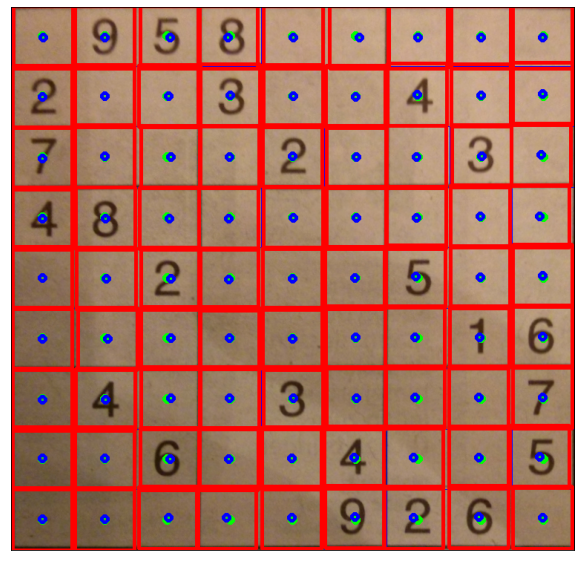

In [155]:
ones_length = (kernel_shape[0]+kernel_shape[1])//20
v_se = centering_se(kernel_shape, (2,ones_length))
h_se = centering_se(kernel_shape, (ones_length,2))

tt = test_orig.copy()
new_centers = []
for i in range(len(centers)):
  v_mov_range, h_mov_range = (-kernel_shape[0]//5, kernel_shape[0]//5), (-kernel_shape[1]//5, kernel_shape[1]//5)
  if (i<9)            : h_mov_range = (0, kernel_shape[1]//5)
  elif (i>71)         : h_mov_range = (-kernel_shape[1]//5, 0)
  if (i%9 == 0)       : v_mov_range = (0, kernel_shape[1]//5)
  elif ((i+1)%9 == 0) : v_mov_range = (-kernel_shape[1]//5, 0)

  new_centers.append(recentre(transformed_processed, centers[i], h_se, v_se, h_mov_range, v_mov_range))

for center in new_centers:
  cv2.circle(tt, center, radius, (255,0,0), thickness)
  cv2.rectangle(tt, (center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2), (center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2), (0,0,255), thickness)  

show_image_with_pyplot(tt, False)

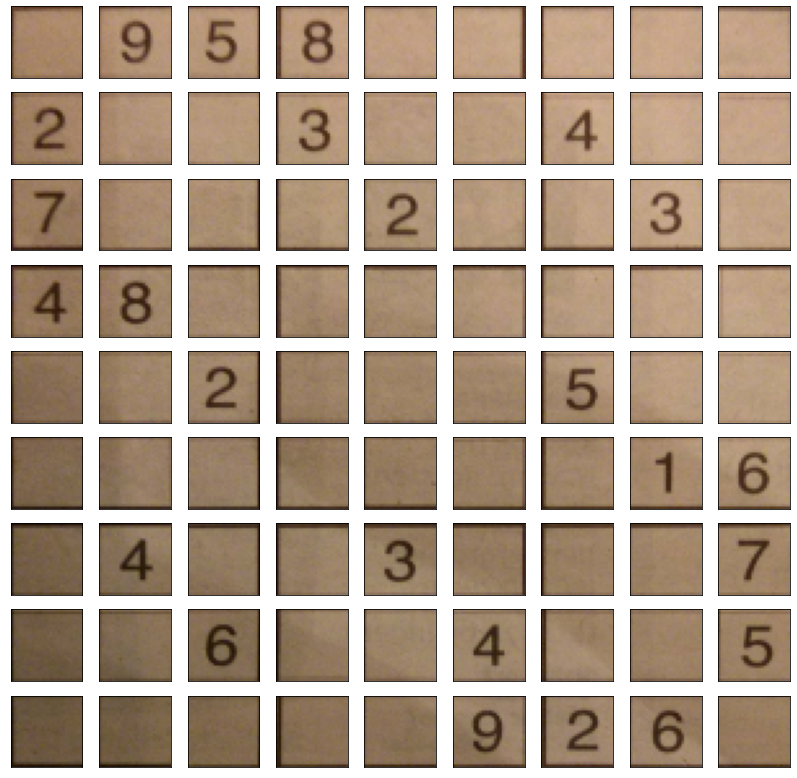

In [157]:
# extracting digits
fig, axes = plt.subplots(9, 9)
fig.set_size_inches(14,14)
i=0
for center in new_centers:
  top_l = [center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2]
  top_r = [center[0]+kernel_shape[1]//2, center[1]-kernel_shape[0]//2]
  bottom_l = [center[0]-kernel_shape[1]//2, center[1]+kernel_shape[0]//2]
  bottom_r = [center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2]

  M = cv2.getPerspectiveTransform(np.float32([top_l, top_r, bottom_l, bottom_r]), np.float32([[0,0], [28,0], [0,28], [28,28]]))
  dst = cv2.warpPerspective(transformed_orig,M,(28,28))
  # if(np.sum(dst) > 255*30):
  show_image_with_pyplot(dst, grayscale=False, ax=axes[i%9,i//9])
  # else:
    # show_image_with_pyplot(dst+255, grayscale=True, ax=axes[i%9,i//9])
  i+=1
  # top_l, top_r, bottom_l, bottom_r = (center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2), (center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2)
  # cv2.circle(tt, center, 5, (255,0,0), 10)
  # cv2.rectangle(tt, (center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2), (center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2), (0,0,255), 5) 